In [8]:
import pandas as pd 

df = pd.read_csv('Final_Dataset_final5.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,TAGLN2,SLAMF7,ETNPPL,SEC24B,RN7SL55P,MIR576,ARSJ,EFCAB4A,TOLLIP,RAB11FIP4,...,SNRPN,CLCN1,OR51E2,GALNT10,BAI3,REEP1,CDCA3,PIK3AP1,LARP6,USP47
0,0.507034,0.395757,0.716595,0.734249,0.734249,0.734249,0.779868,0.254856,0.255133,0.867022,...,0.019400,0.623900,0.448381,0.235788,-0.184713,-0.244834,-0.456083,-0.957985,-0.304092,-0.612955
1,-0.313605,0.715556,0.169356,0.171480,0.171480,0.171480,0.218132,0.616770,0.614806,0.539965,...,-0.473862,-0.154963,-0.683696,-0.562563,-0.282885,-1.891387,0.193915,-0.120336,-0.045259,-0.445204
2,-0.648256,-0.678108,0.532048,0.544465,0.544465,0.544465,0.590432,0.647634,0.645479,-0.619596,...,-3.502938,-1.413065,-1.767220,0.039548,-0.066872,0.756756,-0.509003,0.418008,-0.176092,-1.093550
3,-0.691173,-0.718001,0.396383,0.404950,0.404950,0.404950,0.451173,-2.390197,-2.373544,-0.457661,...,-0.835289,-1.321317,-0.534740,-0.284119,-0.427121,-0.416668,-0.622271,0.855867,-0.400115,-0.412463
4,-0.590884,-0.624780,-0.431316,-0.446239,-0.446239,-0.446239,-0.398453,-1.666852,-1.654678,-0.457661,...,-0.042511,-0.453063,0.831794,-0.388086,-0.277170,-1.568465,0.117702,-0.456673,-1.199107,0.116959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,-0.629690,-0.660851,0.337245,0.344133,0.344133,0.344133,0.390468,0.718267,0.715674,2.518113,...,0.727706,0.117364,0.747816,0.476487,-0.147897,0.883816,0.622696,0.326760,0.157630,-0.122293
398,-0.238381,-0.297121,0.355756,0.363170,0.363170,0.363170,0.409470,1.161295,1.155960,-0.584662,...,0.901805,0.115000,0.206420,0.428219,-0.371763,0.685686,1.443251,-0.622498,-1.134274,-0.418116
399,0.385810,0.283077,0.891301,0.913914,0.913914,0.913914,0.959202,-0.177246,-0.174294,0.267791,...,1.047756,-0.698233,-0.818548,0.840988,0.117104,-1.140071,0.658338,0.132193,-1.430925,1.141193
400,-0.633399,-0.664298,0.381625,0.389774,0.389774,0.389774,0.436024,0.693755,0.691314,-0.451929,...,1.501786,1.282492,-0.167370,1.531718,-0.343058,1.121865,-1.269537,-0.446910,1.241274,0.198240


In [125]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch.nn import Linear
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import os

X = df.drop(columns=['Patient_ID', 'Age_Above_64']).values
y = df['Age_Above_64'].values

X_resampled = X
y_resampled = y
edges = kneighbors_graph(X_resampled, n_neighbors=10, mode='connectivity').nonzero()
edge_index = torch.tensor(edges, dtype=torch.long)

# Convert features and labels to PyTorch tensors
x = torch.tensor(X_resampled, dtype=torch.float)
y = torch.tensor(y_resampled, dtype=torch.long)

# Base Training Function
def train_gnn(model, data, train_idx, val_idx, epochs=2000, lr=0.01, patience=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.NLLLoss()
    best_val_loss = np.inf
    best_model_state = None
    epochs_no_improve = 0

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()

        # Training accuracy
        train_pred = out[train_idx].argmax(dim=1)
        train_acc = accuracy_score(data.y[train_idx].numpy(), train_pred.numpy())
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_loss = criterion(val_out[val_idx], data.y[val_idx])
            val_pred = val_out[val_idx].argmax(dim=1)
            val_acc = accuracy_score(data.y[val_idx].numpy(), val_pred.numpy())
            val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                break

    # Restore the best model
    model.load_state_dict(best_model_state)
    return model, train_accuracies, val_accuracies

# Model definitions
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.4, enc_dim=32):
        super(GCN, self).__init__()
        
        # First GCN Layer
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim)  # Batch normalization
        
        # Second GCN Layer (Final Output)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.batch_norm2 = torch.nn.BatchNorm1d(out_dim)  

        self.dropout = dropout

    def forward(self, x, edge_index):
        # First Layer
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)  # Normalize activations
        x = F.elu(x)  # Better than ReLU
        x = F.dropout(x, self.dropout, training=self.training)

        # Second Layer (Output)
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)  # Normalize activations
        
        return F.log_softmax(x, dim=1)  # Class probabilities



class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=3, dropout=0.4, enc_dim=32):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1, dropout=dropout)
        self.dropout = dropout
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim * heads)  
        self.batch_norm2 = torch.nn.BatchNorm1d(out_dim)  

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.batch_norm1(x)  # Apply batch normalization
        x = F.dropout(x, self.dropout, training=self.training)
        
        # Second GAT layer
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)  # Apply batch normalization
        
        return F.log_softmax(x, dim=1)


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, enc_dim, hidden_dim, out_dim, dropout= 0.2):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Create a directory to save models
model_save_dir = 'saved_models'
os.makedirs(model_save_dir, exist_ok=True)

# Cross-validation setup
kf = KFold(n_splits=10, shuffle=True)
results = {"GCN": [], "GAT": [], "GraphSAGE": [], "Random Forest": []}
all_train_accuracies = {"GCN": [], "GAT": [], "GraphSAGE": []}
all_val_accuracies = {"GCN": [], "GAT": [], "GraphSAGE": []}

models = {
    "GCN": GCN,
    "GAT": GAT,
    "GraphSAGE": GraphSAGE
}

for model_name, ModelClass in models.items():
    print(f"\n=== Training {model_name} ===")
    fold_results = []
    best_auc = 0
    best_model_state = None

    for fold, (train_idx, test_idx) in enumerate(kf.split(x)):
        print(f"\nFold {fold + 1}")
        train_idx = torch.tensor(train_idx, dtype=torch.long)
        test_idx = torch.tensor(test_idx, dtype=torch.long)

        train_subset, val_subset = train_test_split(train_idx.numpy(), test_size=0.2)
        train_subset = torch.tensor(train_subset, dtype=torch.long)
        val_subset = torch.tensor(val_subset, dtype=torch.long)

        # Prepare the data object
        data = Data(x=x, edge_index=edge_index, y=y)

        # Initialize model
        model = ModelClass(
            in_dim=data.num_features,
            enc_dim=32,
            hidden_dim=16,
            out_dim=len(torch.unique(data.y))
        )
        
        trained_model, train_accuracies, val_accuracies = train_gnn(model, data, train_subset, val_subset)

        # Store accuracies
        all_train_accuracies[model_name].append(train_accuracies)
        all_val_accuracies[model_name].append(val_accuracies)

        # Test evaluation
        trained_model.eval()
        with torch.no_grad():
            logits = trained_model(data.x, data.edge_index)
            pred = logits.argmax(dim=1)

            acc = accuracy_score(data.y[test_idx].numpy(), pred[test_idx].numpy())
            f1 = f1_score(data.y[test_idx].numpy(), pred[test_idx].numpy(), average='weighted')
            precision = precision_score(data.y[test_idx].numpy(), pred[test_idx].numpy(), average='weighted')
            recall = recall_score(data.y[test_idx].numpy(), pred[test_idx].numpy(), average='weighted')
            prob = torch.exp(logits)[test_idx, 1].numpy()  # Probabilities for AUC
            auc = roc_auc_score(data.y[test_idx].numpy(), prob)

        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")
        fold_results.append((acc, f1, precision, recall, auc))

        # Save the model with the highest AUC
        if auc > best_auc:
            best_auc = auc
            best_model_state = trained_model.state_dict()

    results[model_name] = np.mean(fold_results, axis=0)

    if best_model_state is not None:
        torch.save(best_model_state, os.path.join(model_save_dir, f"{model_name}_best_model.pth"))

print("\n=== Training Random Forest ===")
rf_fold_results = []
kf_rf = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in kf_rf.split(X_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    rf_model = RandomForestClassifier(n_estimators = 50)
    rf_model.fit(X_train, y_train)

    rf_pred = rf_model.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred, average='weighted')
    rf_precision = precision_score(y_test, rf_pred, average='weighted')
    rf_recall = recall_score(y_test, rf_pred, average='weighted')
    rf_prob = rf_model.predict_proba(X_test)[:, 1] 
    rf_auc = roc_auc_score(y_test, rf_prob)

    print(f"Random Forest - Accuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}, Precision: {rf_precision:.4f}, Recall: {rf_recall:.4f}, AUC: {rf_auc:.4f}")
    rf_fold_results.append((rf_acc, rf_f1, rf_precision, rf_recall, rf_auc))

# Store Random Forest results
results["Random Forest"] = np.mean(rf_fold_results, axis=0)

# Aggregate results
print("\n=== Final Cross-Validation Results ===")
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(f"Average Accuracy: {result[0]:.4f}")
    print(f"Average F1 Score: {result[1]:.4f}")
    print(f"Average Precision: {result[2]:.4f}")
    print(f"Average Recall: {result[3]:.4f}")
    print(f"Average AUC: {result[4]:.4f}")



=== Training GCN ===

Fold 1
Accuracy: 0.6829, F1: 0.6859, Precision: 0.6897, Recall: 0.6829, AUC: 0.6621

Fold 2
Accuracy: 0.7561, F1: 0.7477, Precision: 0.7553, Recall: 0.7561, AUC: 0.7675

Fold 3
Accuracy: 0.7250, F1: 0.7160, Precision: 0.7158, Recall: 0.7250, AUC: 0.7225

Fold 4
Accuracy: 0.7000, F1: 0.6900, Precision: 0.6835, Recall: 0.7000, AUC: 0.6928

Fold 5
Accuracy: 0.6500, F1: 0.6500, Precision: 0.6500, Recall: 0.6500, AUC: 0.7775

Fold 6
Accuracy: 0.7000, F1: 0.6992, Precision: 0.7020, Recall: 0.7000, AUC: 0.8075

Fold 7
Accuracy: 0.7750, F1: 0.7721, Precision: 0.7702, Recall: 0.7750, AUC: 0.7083

Fold 8
Accuracy: 0.8250, F1: 0.8331, Precision: 0.8509, Recall: 0.8250, AUC: 0.8602

Fold 9
Accuracy: 0.7000, F1: 0.6645, Precision: 0.6647, Recall: 0.7000, AUC: 0.6696

Fold 10
Accuracy: 0.7500, F1: 0.7381, Precision: 0.7433, Recall: 0.7500, AUC: 0.7363

=== Training GAT ===

Fold 1
Accuracy: 0.7561, F1: 0.7501, Precision: 0.7481, Recall: 0.7561, AUC: 0.7280

Fold 2
Accuracy: 0.

/var/folders/1f/j0sxlwdj28bgs82pftfkmxwh0000gn/T/ipykernel_54830/1490060419.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_

SHAP values shape: (402, 117, 2)
SHAP summary for class 0
Feature Importance for class 0 based on SHAP values:
             Feature  Mean Absolute SHAP Value
SNRPN          SNRPN                  0.045824
LINC01091  LINC01091                  0.038960
DHX36          DHX36                  0.036708
GFOD2          GFOD2                  0.035471
KIF15          KIF15                  0.035388
...              ...                       ...
PRKAB1        PRKAB1                  0.005209
CLCN1          CLCN1                  0.004242
CDC14B        CDC14B                  0.004237
TOLLIP        TOLLIP                  0.004226
MIR576        MIR576                  0.003928

[117 rows x 2 columns]


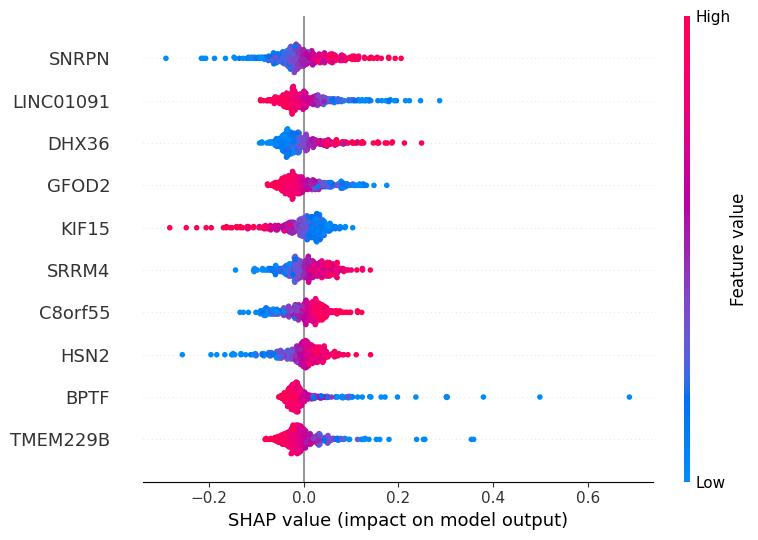

SHAP summary for class 1
Feature Importance for class 1 based on SHAP values:
             Feature  Mean Absolute SHAP Value
SNRPN          SNRPN                  0.045824
LINC01091  LINC01091                  0.038960
DHX36          DHX36                  0.036708
GFOD2          GFOD2                  0.035471
KIF15          KIF15                  0.035388
...              ...                       ...
PRKAB1        PRKAB1                  0.005209
CLCN1          CLCN1                  0.004242
CDC14B        CDC14B                  0.004237
TOLLIP        TOLLIP                  0.004226
MIR576        MIR576                  0.003928

[117 rows x 2 columns]


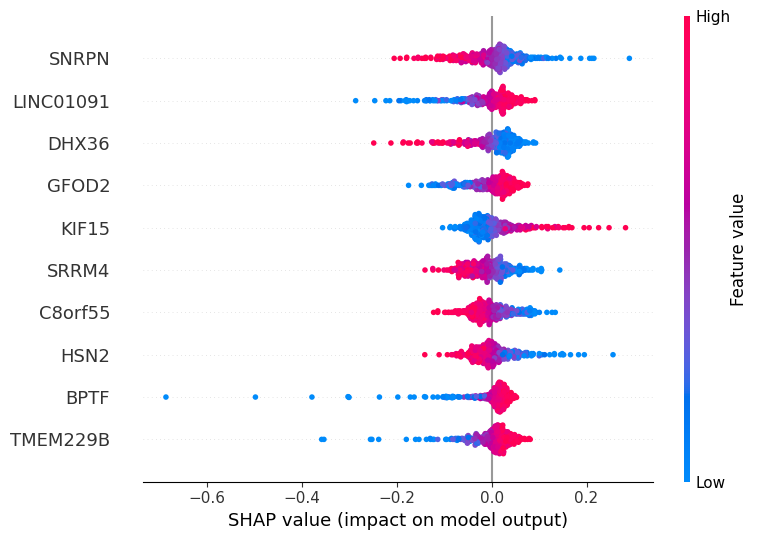

In [126]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.neighbors import kneighbors_graph

# ---------------------------
# GraphSAGE Model Definition
# ---------------------------
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, enc_dim, hidden_dim, out_dim, dropout=0.):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, enc_dim),
            nn.BatchNorm1d(enc_dim),
            nn.ReLU()
        )
        self.conv1 = SAGEConv(enc_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index):
        x = self.encoder(x)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# ---------------------------
# Load Dataset
# ---------------------------
# Assuming `df` is defined earlier in the code with appropriate data
df = df.drop(columns=['Patient_ID']) 
X = df.drop(columns=['Age_Above_64']).values
y = df['Age_Above_64'].values

# ---------------------------
# Create Graph Structure
# ---------------------------
edges = kneighbors_graph(X, n_neighbors=10, mode='connectivity').nonzero()
edge_index = torch.tensor(np.array(edges), dtype=torch.long)
if edge_index.shape[0] != 2:
    edge_index = edge_index.T  
    
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

# ---------------------------
# Load Best Model
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = data.num_features
output_dim = len(torch.unique(data.y))
hidden_dim = 32
enc_dim = 64
dropout_rate = 0.3
model_path = 'saved_models/best_model_GraphSAGE.pth'
best_model = GraphSAGE(in_dim=input_dim, enc_dim=enc_dim, hidden_dim=hidden_dim,
                       out_dim=output_dim, dropout=dropout_rate).to(device)
try:
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    best_model.eval()
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found.")
    exit(1)

def predict_fn(x_input):
    x_tensor = torch.tensor(x_input, dtype=torch.float32).to(device)
    if x_tensor.shape[0] != data.x.shape[0]:
        num_nodes = x_tensor.shape[0]
        valid_mask = (data.edge_index[0] < num_nodes) & (data.edge_index[1] < num_nodes)
        edge_index_subset = data.edge_index[:, valid_mask].to(device)
    else:
        edge_index_subset = data.edge_index.to(device)
    with torch.no_grad():
        logits = best_model(x_tensor, edge_index_subset)
        probs = torch.exp(logits)
    return probs.cpu().numpy()

# ---------------------------
# SHAP Values Calculation
# ---------------------------
X_np = data.x.cpu().numpy()
feature_names = df.drop(columns=['Age_Above_64']).columns.tolist()

X_background = shap.sample(X_np, 100)
explainer_shap = shap.KernelExplainer(predict_fn, X_background)
shap_values = explainer_shap.shap_values(X_np)

print("SHAP values shape:", np.array(shap_values).shape)

# ---------------------------
# Calculate and Print SHAP Values and Feature Importance
# ---------------------------
if isinstance(shap_values, list) and shap_values[0].ndim == 2:
    # Get SHAP values for class 0
    class_shap_values = shap_values[0]
    
    # Create a DataFrame to hold feature names and SHAP values
    shap_df = pd.DataFrame(class_shap_values, columns=feature_names)
    
    # Calculate mean absolute SHAP values for feature importance
    mean_abs_shap = np.abs(shap_df).mean(axis=0)
    
    # Combine the feature names with their mean absolute SHAP values
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean Absolute SHAP Value': mean_abs_shap
    })
    
    # Sort features by their importance
    importance_df = importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)
    
    # Print the feature importance
    print("Feature Importance based on SHAP values:")
    print(importance_df)
    
    # Generate SHAP summary plot
    shap.summary_plot(class_shap_values, X_np, feature_names=feature_names, max_display=10)
    plt.savefig("shap_summary_plot_class_0.png")  # Save the plot immediately after creating it
    plt.close()  # Close the plot to free memory

else:
    # For multi-class outputs, iterate over classes
    for class_idx in range(shap_values.shape[2]):
        print(f"SHAP summary for class {class_idx}")
        
        # Get SHAP values for the current class
        class_shap_values = shap_values[:, :, class_idx]
        
        # Create a DataFrame for feature importance
        shap_df = pd.DataFrame(class_shap_values, columns=feature_names)
        
        # Calculate mean absolute SHAP values for feature importance
        mean_abs_shap = np.abs(shap_df).mean(axis=0)
        
        # Combine the feature names with their mean absolute SHAP values
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean Absolute SHAP Value': mean_abs_shap
        })
        
        # Sort features by their importance
        importance_df = importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)
        
        # Print the feature importance
        print(f"Feature Importance for class {class_idx} based on SHAP values:")
        print(importance_df)

        # Generate SHAP summary plot
        shap.summary_plot(class_shap_values, X_np, feature_names=feature_names, max_display=10)
        plt.savefig(f"shap_summary_plot_class_{class_idx}.png")  # Save each class plot
        plt.close()  # Close the plot to free memory


In [ ]:
# plt.savefig("shap_summary_plot.png")


In [172]:
# plt.savefig("shap_summary_plot.png")
plt.close()

In [10]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch.nn import Linear
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import os

X = df.drop(columns=['Patient_ID', 'Age_Above_64']).values
y = df['Age_Above_64'].values

X_resampled = X
y_resampled = y
edges = kneighbors_graph(X_resampled, n_neighbors=10, mode='connectivity').nonzero()
edge_index = torch.tensor(edges, dtype=torch.long)

# Convert features and labels to PyTorch tensors
x = torch.tensor(X_resampled, dtype=torch.float)
y = torch.tensor(y_resampled, dtype=torch.long)

# Base Training Function
def train_gnn(model, data, train_idx, val_idx, epochs=2000, lr=0.01, patience=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.NLLLoss()
    best_val_loss = np.inf
    best_model_state = None
    epochs_no_improve = 0

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()

        # Training accuracy
        train_pred = out[train_idx].argmax(dim=1)
        train_acc = accuracy_score(data.y[train_idx].numpy(), train_pred.numpy())
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_loss = criterion(val_out[val_idx], data.y[val_idx])
            val_pred = val_out[val_idx].argmax(dim=1)
            val_acc = accuracy_score(data.y[val_idx].numpy(), val_pred.numpy())
            val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                break

    # Restore the best model
    model.load_state_dict(best_model_state)
    return model, train_accuracies, val_accuracies

# Model definitions
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.4, enc_dim=32):
        super(GCN, self).__init__()
        
        # First GCN Layer
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim)
        
        # Second GCN Layer (Final Output)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.batch_norm2 = torch.nn.BatchNorm1d(out_dim)  

        self.dropout = dropout

    def forward(self, x, edge_index):
        # First Layer
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.elu(x)
        x = F.dropout(x, self.dropout, training=self.training)

        # Second Layer (Output)
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=3, dropout=0.4, enc_dim=32):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1, dropout=dropout)
        self.dropout = dropout
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim * heads)  
        self.batch_norm2 = torch.nn.BatchNorm1d(out_dim)  

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.batch_norm1(x)
        x = F.dropout(x, self.dropout, training=self.training)
        
        # Second GAT layer
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, enc_dim, hidden_dim, out_dim, dropout=0.2):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model_save_dir = 'saved_models'
os.makedirs(model_save_dir, exist_ok=True)

kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Added random_state for reproducibility

fold_results = {
    "GCN": {"accuracy": [], "f1": [], "precision": [], "recall": [], "auc": []},
    "GAT": {"accuracy": [], "f1": [], "precision": [], "recall": [], "auc": []},
    "GraphSAGE": {"accuracy": [], "f1": [], "precision": [], "recall": [], "auc": []},
    "Random Forest": {"accuracy": [], "f1": [], "precision": [], "recall": [], "auc": []}
}

all_train_accuracies = {"GCN": [], "GAT": [], "GraphSAGE": []}
all_val_accuracies = {"GCN": [], "GAT": [], "GraphSAGE": []}

models = {
    "GCN": GCN,
    "GAT": GAT,
    "GraphSAGE": GraphSAGE
}

for model_name, ModelClass in models.items():
    print(f"\n=== Training {model_name} ===")
    best_auc = 0
    best_model_state = None

    for fold, (train_idx, test_idx) in enumerate(kf.split(x)):
        print(f"\nFold {fold + 1}")
        train_idx = torch.tensor(train_idx, dtype=torch.long)
        test_idx = torch.tensor(test_idx, dtype=torch.long)

        train_subset, val_subset = train_test_split(train_idx.numpy(), test_size=0.2, random_state=42)
        train_subset = torch.tensor(train_subset, dtype=torch.long)
        val_subset = torch.tensor(val_subset, dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y=y)

        model = ModelClass(
            in_dim=data.num_features,
            enc_dim=32,
            hidden_dim=16,
            out_dim=len(torch.unique(data.y))
        )
        
        trained_model, train_accuracies, val_accuracies = train_gnn(model, data, train_subset, val_subset)

        all_train_accuracies[model_name].append(train_accuracies)
        all_val_accuracies[model_name].append(val_accuracies)

        trained_model.eval()
        with torch.no_grad():
            logits = trained_model(data.x, data.edge_index)
            pred = logits.argmax(dim=1)

            acc = accuracy_score(data.y[test_idx].numpy(), pred[test_idx].numpy())
            f1 = f1_score(data.y[test_idx].numpy(), pred[test_idx].numpy(), average='weighted')
            precision = precision_score(data.y[test_idx].numpy(), pred[test_idx].numpy(), average='weighted')
            recall = recall_score(data.y[test_idx].numpy(), pred[test_idx].numpy(), average='weighted')
            prob = torch.exp(logits)[test_idx, 1].numpy()  # Probabilities for AUC
            auc = roc_auc_score(data.y[test_idx].numpy(), prob)

        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")
        
        # Store fold results
        fold_results[model_name]["accuracy"].append(acc)
        fold_results[model_name]["f1"].append(f1)
        fold_results[model_name]["precision"].append(precision)
        fold_results[model_name]["recall"].append(recall)
        fold_results[model_name]["auc"].append(auc)

        # Save the model with the highest AUC
        if auc > best_auc:
            best_auc = auc
            best_model_state = trained_model.state_dict()

    if best_model_state is not None:
        torch.save(best_model_state, os.path.join(model_save_dir, f"{model_name}_best_model.pth"))

print("\n=== Training Random Forest ===")
kf_rf = KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf_rf.split(X_resampled)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_model.fit(X_train, y_train)

    rf_pred = rf_model.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred, average='weighted')
    rf_precision = precision_score(y_test, rf_pred, average='weighted')
    rf_recall = recall_score(y_test, rf_pred, average='weighted')
    rf_prob = rf_model.predict_proba(X_test)[:, 1] 
    rf_auc = roc_auc_score(y_test, rf_prob)

    print(f"Random Forest - Accuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}, Precision: {rf_precision:.4f}, Recall: {rf_recall:.4f}, AUC: {rf_auc:.4f}")
    
    # Store fold results
    fold_results["Random Forest"]["accuracy"].append(rf_acc)
    fold_results["Random Forest"]["f1"].append(rf_f1)
    fold_results["Random Forest"]["precision"].append(rf_precision)
    fold_results["Random Forest"]["recall"].append(rf_recall)
    fold_results["Random Forest"]["auc"].append(rf_auc)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (10-Fold CV)")
print("="*80)
print("Note: All metrics reported below are from 10-fold cross-validation")
print("Format: Mean ± Standard Deviation")
print("="*80)

metrics = ["accuracy", "f1", "precision", "recall", "auc"]
metric_names = ["Accuracy", "F1 Score", "Precision", "Recall", "AUC"]

for model_name in fold_results.keys():
    print(f"\n{model_name.upper()}:")
    print("-" * 40)
    
    for metric, metric_name in zip(metrics, metric_names):
        values = fold_results[model_name][metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric_name:>12}: {mean_val:.4f} ± {std_val:.4f}")

print("\n" + "="*80)
print("MODEL STABILITY ASSESSMENT")
print("="*80)
print()

for model_name in fold_results.keys():
    print(f"{model_name}:")
    for metric, metric_name in zip(metrics, metric_names):
        values = fold_results[model_name][metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
        print(f"  {metric_name} CV: {cv:.2f}%")
    print()


/var/folders/1f/j0sxlwdj28bgs82pftfkmxwh0000gn/T/ipykernel_10727/3429978390.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  edge_index = torch.tensor(edges, dtype=torch.long)



=== Training GCN ===

Fold 1
Accuracy: 0.7073, F1: 0.6859, Precision: 0.6997, Recall: 0.7073, AUC: 0.7000

Fold 2
Accuracy: 0.8537, F1: 0.8420, Precision: 0.8541, Recall: 0.8537, AUC: 0.8152

Fold 3
Accuracy: 0.7750, F1: 0.7662, Precision: 0.7675, Recall: 0.7750, AUC: 0.7892

Fold 4
Accuracy: 0.7000, F1: 0.6786, Precision: 0.6935, Recall: 0.7000, AUC: 0.6853

Fold 5
Accuracy: 0.6750, F1: 0.6792, Precision: 0.6842, Recall: 0.6750, AUC: 0.7147

Fold 6
Accuracy: 0.6250, F1: 0.6389, Precision: 0.6714, Recall: 0.6250, AUC: 0.6042

Fold 7
Accuracy: 0.5750, F1: 0.5634, Precision: 0.5580, Recall: 0.5750, AUC: 0.5653

Fold 8
Accuracy: 0.8500, F1: 0.8429, Precision: 0.8567, Recall: 0.8500, AUC: 0.8846

Fold 9
Accuracy: 0.7500, F1: 0.7567, Precision: 0.7781, Recall: 0.7500, AUC: 0.7806

Fold 10
Accuracy: 0.7250, F1: 0.7234, Precision: 0.7227, Recall: 0.7250, AUC: 0.8177

=== Training GAT ===

Fold 1
Accuracy: 0.7073, F1: 0.6736, Precision: 0.7090, Recall: 0.7073, AUC: 0.7897

Fold 2
Accuracy: 0.

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.neighbors import kneighbors_graph


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, enc_dim, hidden_dim, out_dim, dropout=0.):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, enc_dim),
            nn.BatchNorm1d(enc_dim),
            nn.ReLU()
        )
        self.conv1 = SAGEConv(enc_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index):
        x = self.encoder(x)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

df = df.drop(columns=['Patient_ID']) 
X = df.drop(columns=['Age_Above_64']).values
y = df['Age_Above_64'].values


edges = kneighbors_graph(X, n_neighbors=10, mode='connectivity').nonzero()
edge_index = torch.tensor(np.array(edges), dtype=torch.long)
if edge_index.shape[0] != 2:
    edge_index = edge_index.T  
    
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = data.num_features
output_dim = len(torch.unique(data.y))
hidden_dim = 32
enc_dim = 64
dropout_rate = 0.3
model_path = 'saved_models/best_model_GraphSAGE.pth'
best_model = GraphSAGE(in_dim=input_dim, enc_dim=enc_dim, hidden_dim=hidden_dim,
                       out_dim=output_dim, dropout=dropout_rate).to(device)
try:
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    best_model.eval()
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found.")
    exit(1)

def predict_fn(x_input):
    x_tensor = torch.tensor(x_input, dtype=torch.float32).to(device)
    if x_tensor.shape[0] != data.x.shape[0]:
        num_nodes = x_tensor.shape[0]
        valid_mask = (data.edge_index[0] < num_nodes) & (data.edge_index[1] < num_nodes)
        edge_index_subset = data.edge_index[:, valid_mask].to(device)
    else:
        edge_index_subset = data.edge_index.to(device)
    with torch.no_grad():
        logits = best_model(x_tensor, edge_index_subset)
        probs = torch.exp(logits)
    return probs.cpu().numpy()


X_np = data.x.cpu().numpy()
feature_names = df.drop(columns=['Age_Above_64']).columns.tolist()

X_background = shap.sample(X_np, 100)
explainer_shap = shap.KernelExplainer(predict_fn, X_background)
shap_values = explainer_shap.shap_values(X_np)

print("SHAP values shape:", np.array(shap_values).shape)


if isinstance(shap_values, list) and shap_values[0].ndim == 2:
    class_shap_values = shap_values[0]
    
    shap_df = pd.DataFrame(class_shap_values, columns=feature_names)
    
    mean_abs_shap = np.abs(shap_df).mean(axis=0)
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean Absolute SHAP Value': mean_abs_shap
    })
    
    importance_df = importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)
    
    print("Feature Importance based on SHAP values:")
    print(importance_df)
    
    shap.summary_plot(class_shap_values, X_np, feature_names=feature_names, max_display=10)
    plt.savefig("shap_summary_plot_class_0.png")  
    plt.close()  
else:
    for class_idx in range(shap_values.shape[2]):
        print(f"SHAP summary for class {class_idx}")
        
        class_shap_values = shap_values[:, :, class_idx]
        
        shap_df = pd.DataFrame(class_shap_values, columns=feature_names)
        
        mean_abs_shap = np.abs(shap_df).mean(axis=0)
        
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean Absolute SHAP Value': mean_abs_shap
        })
        
        importance_df = importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)
        
        print(f"Feature Importance for class {class_idx} based on SHAP values:")
        print(importance_df)

        shap.summary_plot(class_shap_values, X_np, feature_names=feature_names, max_display=10)
        plt.savefig(f"shap_summary_plot_class_{class_idx}.png")  # Save each class plot
        plt.close() 